In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import networkx as nx
import pandas as pd

from sys import stdout

from functools import partial
from multiprocessing import Pool

In [2]:
G = nx.read_gml("ps_graph.gml")

In [3]:
G = max(nx.connected_component_subgraphs(G), key=len)

N = nx.number_of_nodes(G)

degrees = nx.degree(G)

sorted_nodes = np.array([int(n) for n in degrees.keys()])
sorted_nodes.sort()

degrees = nx.degree(G)

# sort keys into integer order
sorted_nodes = np.array([int(n) for n in degrees.keys()])
sorted_nodes.sort()

# construct array of degrees in integer order of nodes
degrees = np.array([degrees[int(n)] for n in sorted_nodes])
degree_sort = degrees.argsort()[::-1]

# when did each node appaear in the network (i)
order_of_appearance = np.array([np.where(degree_sort==n)[0][0] + 1 for n in sorted_nodes])

polar_df = pd.read_csv("polar_coords.txt", delimiter="\t")
polar_coords = polar_df.values
polar_coords = polar_coords[order_of_appearance-1]
# true_coords = {n: {"r" : x[0], "theta" : x[1]} for n, x in zip(sorted_nodes, polar_coords)}
R_true = polar_coords[:,0]
thetas_true = polar_coords[:,1]

In [5]:
# number of attributes 
K = 10
# number of communities
C = 3
# clip value 
clip_value = 1e-8

In [6]:
# artificially create binary attributes from radial coordinates
X = np.zeros((N, K))

for i, theta in enumerate(thetas_true):
    
    id = int(theta * K / (2 * np.pi))
    
    p = np.array([np.exp(-(id-x)**2 / (2 * (10.0)**2) ) for x in range(K)])
    
    r = np.random.rand(K)
    
    X[i][r < p] = 1
    
# clip X
# X = np.clip(X, a_min=clip_value, a_max=1-clip_value)

# observed adjacancy matrix
A = np.array(nx.adjacency_matrix(G).todense())
# clip A
# A = np.clip(A, a_min=clip_value, a_max=1-clip_value)

In [7]:
# PS model parameters -- to estimate in real world network
m = degrees.mean() / 2
T = 0.1
gamma = 2.3
beta = 1. / (gamma - 1)

In [8]:
# determine radial coordinates of nodes
R = 2 * beta * np.log(range(1, N + 1)) + 2 * (1 - beta) * np.log(N) 
R = R[order_of_appearance - 1]

In [9]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def compute_L_G(P):
    
    # clip to avoid error
    A_clip = np.clip(A, a_min=clip_value, a_max=1-clip_value)
    P = np.clip(P, a_min=clip_value, a_max=1-clip_value)
    
    return (A_clip * np.log(P) + (1 - A_clip) * np.log(1 - P)).sum()

def compute_L_X(Q):
    
    # clip to avoid error
    X_clip = np.clip(X, a_min=clip_value, a_max=1-clip_value)
    Q = np.clip(Q, a_min=clip_value, a_max=1-clip_value)
    
    return (X_clip * np.log(Q) + (1 - X_clip) * np.log(1 - Q)).sum()

def compute_likelihood(thetas, M, W, lamb_W, alpha):
    
    F = compute_F(thetas, M)
    P = compute_P(F)
    Q = compute_Q(F, W)
    
    # likelihood of G
    L_G = compute_L_G(P)
    
    # likelihood of X
    L_X = compute_L_X(Q)
    
    # l1 penalty term
    l1 = lamb_W * np.linalg.norm(W, axis=0, ord=1).sum()
    
    # overall likelihood
    likelihood = (1 - alpha) * L_G + alpha * L_X - l1
    
    return L_G, L_X, l1, likelihood

In [10]:
def hyperbolic_distance(thetas, M):
    delta_theta = np.pi - abs(np.pi - abs(thetas[:,None] - M[:,1]))
    x = np.cosh(R[:,None]) * np.cosh(M[:,0]) - np.sinh(R[:,None]) * np.sinh(M[:,0]) * np.cos(delta_theta)
    return np.arccosh(x)

def compute_F(thetas, M):
    h = hyperbolic_distance(thetas, M)
    F = 1 / np.sqrt(2 * np.pi * M[:,2] ** 2) * np.exp(- h ** 2 / (2 * M[:,2] ** 2))
    return np.column_stack([F, np.ones(N)])

def compute_P(F):
    return 1 - np.exp( - F[:,:-1].dot(F[:,:-1].T))

def compute_Q(F, W):
    return np.array([[sigmoid(F[u].dot(W[k].T)) for k in range(K)] for u in range(N)])

def compute_Q_u(F_u, W):
    return np.array([sigmoid(F_u.dot(W[k].T)) for k in range(K)])

def compute_Q__k(F, W_k):
    return np.array([sigmoid(F[u].dot(W_k.T)) for u in range(N)])

In [11]:
def update_theta_u(u, thetas, M, W, eta, alpha):
    
    # compute F
    delta_theta = np.pi - abs(np.pi - abs(thetas[:,None] - M[:,1]))
    x = np.cosh(R[:,None]) * np.cosh(M[:,0]) - np.sinh(R[:,None]) * np.sinh(M[:,0]) * np.cos(delta_theta)
    h = np.arccosh(x)
    F = 1 / np.sqrt(2 * np.pi * M[:,2] ** 2) * np.exp(- h ** 2 / (2 * M[:,2] ** 2))
    
    # partial delta theta partial theta
    partial_delta_theta_u_partial_theta_u = -np.sign(np.pi - abs(thetas[u] - M[:,1])) * -np.sign(thetas[u] - M[:,1]) * 1
    
    # parital h partial theta
    partial_h_u_partial_theta_u = 1 / np.sqrt(x[u] ** 2 - 1) * np.sinh(R[u]) * np.sinh(M[:,0]) * np.sin(delta_theta[u]) * \
    partial_delta_theta_u_partial_theta_u
     
    # partial F partial theta
    partial_F_u_partial_theta_u = - 2 * h[u] / (2 * M[:,2] ** 2) * F[u] *\
    partial_h_u_partial_theta_u
    
    # partial L_G
    partial_L_G_u_partial_F_u = np.array([(A[u] * F[:,c] * np.exp(-F[u].dot(F.T)) / (1 - np.exp(-F[u].dot(F.T))) -\
                                          (1 - A[u]) * F[:,c]).sum() for c in range(C)])
    
    partial_L_G_u_partial_theta_u = partial_L_G_u_partial_F_u.dot(partial_F_u_partial_theta_u)
    
    # partial L_X
    F_u = np.append(F[u], 1)
    Q_u = compute_Q_u(F_u, W)
    partial_L_X_u_partial_F_u = np.array([(X[u] - Q_u).dot(W[:,c]) for c in range(C)])
    partial_L_X_u_partial_theta_u = partial_L_X_u_partial_F_u.dot(partial_F_u_partial_theta_u)
    
    return thetas[u] + eta * ((1 - alpha) * partial_L_G_u_partial_theta_u + alpha * partial_L_X_u_partial_theta_u)

def compute_partial_L_G_c_partial_F_c(c, F):
    
    partial_L_G_c_partial_F_c = np.zeros((N ** 2, N))
    for i in range(N ** 2):
        u = i / N
        v = i - u * N
        p_u = np.zeros(N)
        p_u[u] = F[v, c]
        p_v = np.zeros(N)
        p_v[v] = F[u, c]
        partial_L_G_c_partial_F_c[i] = p_u + p_v
        partial_L_G_c_partial_F_c[i] *= A[u,v] * np.exp(-F[u,c] * F[v,c]) /\
        (1 - np.exp(-F[u,c] * F[v,c])) - (1 - A[u,v])
    
    partial_L_G_c_partial_F_c = partial_L_G_c_partial_F_c.sum(axis=0)
    
    return partial_L_G_c_partial_F_c

def compute_partial_L_X_c_partial_F_c(c, Q, W):
    
    partial_L_X_c_partial_F_c = np.zeros((N * K, N))
    for i in range(N * K):
        u = i / K
        k = i - u * K
        partial_L_X_c_partial_F_c[i, u] = (X[u, k] - Q[u, k]) * W[k, c]
        
    partial_L_X_c_partial_F_c = partial_L_X_c_partial_F_c.sum(axis=0)
    
    return partial_L_X_c_partial_F_c

def update_community_r_c(c, thetas, M, W, eta, alpha):
    
    # compute F
    delta_theta = np.pi - abs(np.pi - abs(thetas[:,None] - M[:,1]))
    x = np.cosh(R[:,None]) * np.cosh(M[:,0]) - np.sinh(R[:,None]) * np.sinh(M[:,0]) * np.cos(delta_theta)
    h = np.arccosh(x)
    F = 1 / np.sqrt(2 * np.pi * M[:,2] ** 2) * np.exp(-h**2 / (2 * M[:,2] ** 2))
    
    # partial h
    partial_h_c_partial_r_c = 1 / np.sqrt(x[:,c] ** 2 - 1) * (np.cosh(R) * np.sinh(M[c,0]) -\
                                                              np.sinh(R) * np.cosh(M[c,0])) * np.cos(delta_theta[:,c])
    # partial F
    partial_F_c_partial_r_c = - 2 * h[:,c] / (2 * M[c, 2] ** 2) * F[:,c] *\
    partial_h_c_partial_r_c
    
    # partial L_G 
    partial_L_G_c_partial_F_c = compute_partial_L_G_c_partial_F_c(c, F)
    partial_L_G_c_partial_r_c = partial_L_G_c_partial_F_c.dot(partial_F_c_partial_r_c)
    
    # partial L_x TODO
    F = np.column_stack([F, np.ones(N)])
    Q = compute_Q(F, W)
    partial_L_X_c_partial_F_c = compute_partial_L_X_c_partial_F_c(c, Q, W)
    partial_L_X_c_partial_r_c = partial_L_X_c_partial_F_c.dot(partial_F_c_partial_r_c)

    return M[c, 0] + eta * ((1 - alpha) * partial_L_G_c_partial_r_c + alpha * partial_L_X_c_partial_r_c)

def update_community_theta_c(c, thetas, M, W, eta, alpha):
    
    # compute F
    delta_theta = np.pi - abs(np.pi - abs(thetas[:,None] - M[:,1]))
    x = np.cosh(R[:,None]) * np.cosh(M[:,0]) - np.sinh(R[:,None]) * np.sinh(M[:,0]) * np.cos(delta_theta)
    h = np.arccosh(x)
    F = 1 / np.sqrt(2 * np.pi * M[:,2] ** 2) * np.exp(-h**2 / (2 * M[:,2] ** 2))
    
    # partial delta theta
    partial_delta_theta_c_partial_theta_c = -np.sign(np.pi - abs(thetas - M[c,1])) * -np.sign(thetas - M[c,1]) * -1
    
    # partial h
    partial_h_c_partial_theta_c = 1 / np.sqrt(x[:,c] ** 2 - 1) * np.sinh(R) * np.sinh(M[c,0]) * np.sin(delta_theta[:,c]) *\
    partial_delta_theta_c_partial_theta_c
    
    # partial F
    partial_F_c_partial_theta_c = - 2 * h[:,c] / (2 * M[c, 2] ** 2) * F[:,c] *\
    partial_h_c_partial_theta_c
    
    # partial L_G 
    partial_L_G_c_partial_F_c = compute_partial_L_G_c_partial_F_c(c, F)
    partial_L_G_c_partial_theta_c = partial_L_G_c_partial_F_c.dot(partial_F_c_partial_theta_c)
    
    # partial L_x
    F = np.column_stack([F, np.ones(N)])
    Q = compute_Q(F, W)
    partial_L_X_c_partial_F_c = compute_partial_L_X_c_partial_F_c(c, Q, W)
    partial_L_X_c_partial_theta_c = partial_L_X_c_partial_F_c.dot(partial_F_c_partial_theta_c)

    return M[c, 1] + eta * ((1 - alpha) * partial_L_G_c_partial_theta_c + alpha * partial_L_X_c_partial_theta_c)

def update_community_sd_c(c, thetas, M, W, eta, alpha):
    
    # compute F
    delta_theta = np.pi - abs(np.pi - abs(thetas[:,None] - M[:,1]))
    x = np.cosh(R[:,None]) * np.cosh(M[:,0]) - np.sinh(R[:,None]) * np.sinh(M[:,0]) * np.cos(delta_theta)
    h = np.arccosh(x)
    F = 1 / np.sqrt(2 * np.pi * M[:,2] ** 2) * np.exp( - h ** 2 / (2 * M[:,2] ** 2))
    
    # partial F
    partial_F_c_partial_sd_c = - 2 * np.pi * M[c,2] / np.sqrt((2 * np.pi * M[c,2] ** 2) ** 3) * \
    np.exp(- h[:,c] ** 2 / (2 * M[c,2] ** 2)) + 1 / np.sqrt(2 * np.pi * M[c,2] ** 2) * h[:,c] ** 2 / M[c,2] ** 3 *\
    np.exp(- h[:,c] ** 2 / (2 * M[c,2] ** 2))
    
    # partial L_G 
    partial_L_G_c_partial_F_c = compute_partial_L_G_c_partial_F_c(c, F)
    partial_L_G_c_partial_sd_c = partial_L_G_c_partial_F_c.dot(partial_F_c_partial_sd_c)
    
    # partial L_x 
    F = np.column_stack([F, np.ones(N)])
    Q = compute_Q(F, W)
    partial_L_X_c_partial_F_c = compute_partial_L_X_c_partial_F_c(c, Q, W)
    partial_L_X_c_partial_sd_c = partial_L_X_c_partial_F_c.dot(partial_F_c_partial_sd_c)

    return M[c, 2] + eta * ((1 - alpha) * partial_L_G_c_partial_sd_c + alpha * partial_L_X_c_partial_sd_c)


def update_W_k(k, W, F, eta, lamb, alpha):
    
    # kth row of W
    W_k = W[k]
    
    # kth column of Q
    Q__k = compute_Q__k(F, W_k)
    
    # compute gradient 
    grad = alpha * np.array([(X[:,k] - Q__k).T.dot(F[:,c])
                             for c in range(C + 1)])

    W_k_new = W_k + eta * (grad - lamb * np.sign(W_k))
    
    return W_k_new

In [30]:
# angular co-ordinates of nodes
thetas = np.random.normal(size=(N,), scale=np.pi)

# community matrix M
M = np.zeros((C, 3))
# centre radii
M[:,0] = np.random.normal(size=(C,), loc=R.mean(), scale=R.std())
# center angular coordinate
M[:,1] = np.random.normal(size=(C,), scale=np.pi)
# M[:,1] = np.arange(C) * 2 * np.pi / C
# community standard deviations
M[:,2] = np.random.normal(size=(C,), loc=R.max(), scale=R.std())

# initialise logistic weights
W = np.random.normal(size=(K, C + 1))

In [31]:
M

array([[ 11.24823173,   3.84316396,  10.56803297],
       [ 11.42586631,   1.26351177,  14.22143633],
       [ 12.72363032,  -2.27308943,  15.75209525]])

In [ ]:
eta = 1e-3
alpha = 0.5
lamb_W = 1e-0

minibatch_size = 10
num_processes = 4
pool = Pool(processes=num_processes)

for e in range(1000):
    
    node_order = np.random.permutation(N)
    for mini_batch in range(N / minibatch_size):
        
        idx = node_order[mini_batch * minibatch_size : (mini_batch+1) * minibatch_size]
        thetas_idx = np.array(pool.map(partial(update_theta_u, 
                                       thetas=thetas, M=M, W=W, eta=eta, alpha=alpha), idx))
        thetas[idx] = thetas_idx
        
    if (mini_batch+1) * minibatch_size < N:

        idx = node_order[N / minibatch_size * minibatch_size : ]
        thetas_idx = np.array(pool.map(partial(update_theta_u, 
                                       thetas=thetas, M=M, W=W, eta=eta, alpha=alpha), idx))
        thetas[idx] = thetas_idx
    
#     for u in range(N):
#         thetas[u] = update_theta_u(u, thetas, M, W, eta=eta, alpha=alpha)
    
#     for c in range(C):
#         M[c, 0] = update_community_r_c(c, thetas, M, W, eta, alpha)
        
#     for c in range(C):
#         M[c, 1] = update_community_theta_c(c, thetas, M, W, eta, alpha)
        
#     for c in range(C):
#         M[c, 2] = update_community_sd_c(c, thetas, M, W, eta, alpha)

    M[:, 0] = np.array(pool.map(partial(update_community_r_c, thetas=thetas, M=M, W=W, eta=eta, alpha=alpha), range(C)))
    M[:, 1] = np.array(pool.map(partial(update_community_theta_c, thetas=thetas, M=M, W=W, eta=eta, alpha=alpha), range(C)))
    M[:, 2] = np.array(pool.map(partial(update_community_sd_c, thetas=thetas, M=M, W=W, eta=eta, alpha=alpha), range(C)))
    
    F = compute_F(thetas, M)
    W = np.array(pool.map(partial(update_W_k, F=F, W=W, eta=eta, lamb=lamb_W, alpha=alpha), range(K)))
#     for k in range(K):
#         W[k] = update_W_k(k, W, F, eta=eta, lamb=lamb_W, alpha=alpha)

    L_G, L_X, l1, loss = compute_likelihood(thetas, M, W, lamb_W=lamb_W, alpha=alpha)
    alpha = L_X / (L_G + L_X)
    print e, alpha, L_G, L_X, l1, loss

pool.close()
pool.join()

In [20]:
def polar2cartesian(R, thetas):
    return np.column_stack([R * np.cos(thetas), R * np.sin(thetas)])

In [21]:
nodes = polar2cartesian(R, thetas)
communities = polar2cartesian(M[:,0], M[:,1])

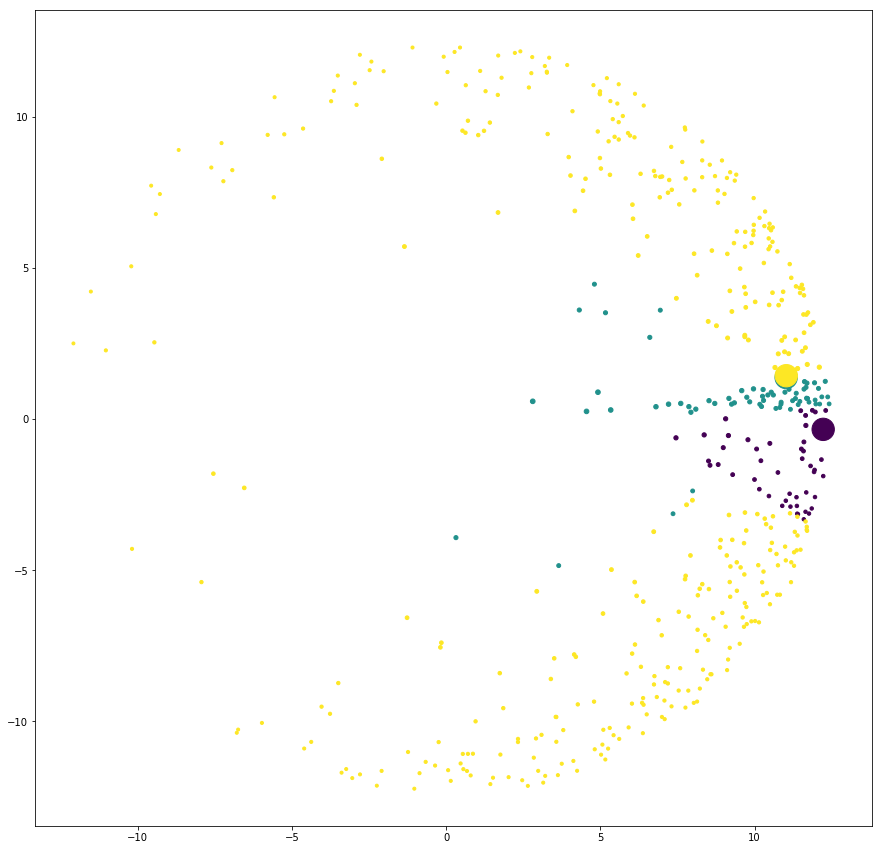

In [22]:
plt.figure(figsize=(15, 15))
# l = N
# for label, i, j in zip(G.nodes(), coords[:l, 0], coords[:l, 1]):
#     plt.annotate(
#         label,
#         xy=(i, j), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
# for label, i, j in zip(range(C), centre_coords[:, 0], centre_coords[:, 1]):
#     plt.annotate(
#         label,
#         xy=(i, j), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

# nodes = np.array(G.nodes())
# for n1, n2 in G.edges():
#     i, = np.where(nodes == n1)
#     j, = np.where(nodes == n2)
#     plt.plot(coords[(i, j), 0], coords[(i, j), 1], c="k", 
#              linewidth = 0.3)
F = compute_F(thetas, M)
ass = F[:,:-1].argmax(axis=1)
plt.scatter(nodes[:,0], nodes[:,1], c=ass, s=F[np.arange(N), ass]*1000)
plt.scatter(communities[:,0], communities[:,1], s=500, c=np.arange(C))

In [25]:
F = compute_F(thetas, M)
P = compute_P(F)

In [26]:
F[:2]

array([[  1.61882072e-01,   8.59749281e-04,   7.48133139e-01,
          1.13630968e-14,   2.48821403e-01,   2.18619222e-01,
          1.58335155e-01,   5.79863472e-01,   9.33273928e-02,
          4.71101319e-01,   1.00000000e+00],
       [  1.41395059e-01,   2.19377091e-03,   5.86275819e-01,
          9.44266100e-11,   5.62028401e-01,   1.54492545e-01,
          7.18943864e-02,   6.68213814e-01,   2.28189752e-01,
          2.03692992e-01,   1.00000000e+00]])

In [89]:
zip(P[0], A[0])

[(0.010232266665981204, 0),
 (0.0014446560444149048, 1),
 (0.00049482789941368566, 1),
 (0.00097078775001024908, 1),
 (0.00032606838796545023, 0),
 (0.0015162260682594075, 0),
 (0.00073438046076956809, 1),
 (0.00010271346333956544, 0),
 (0.001552402819245513, 1),
 (0.000306008654768819, 0),
 (5.3600750681614961e-05, 0),
 (0.00096324496438870977, 0),
 (0.0003660287103894877, 1),
 (0.0023036879424276346, 0),
 (0.0001616421428386472, 0),
 (0.0011338348061999959, 1),
 (0.00019151245190129895, 0),
 (0.010340076065972648, 0),
 (0.00034250208943309435, 0),
 (6.3533509113922193e-05, 1),
 (3.4941016074263587e-05, 0),
 (0.00053563829308989064, 0),
 (3.1291137500111255e-05, 0),
 (3.9891200870889598e-05, 1),
 (0.0012262454474422091, 0),
 (0.00018530639297631435, 0),
 (8.7287759182319569e-05, 1),
 (0.00020672426015433398, 0),
 (9.7245938489587402e-06, 1),
 (0.0010581812576287986, 1),
 (0.00015066521747308936, 0),
 (0.00062342724105024505, 1),
 (0.00026565425513125351, 1),
 (2.2219324639416449e-05, 

In [90]:
F[0]

array([ 0.07105505,  0.06484647,  0.01812685,  0.00960588,  0.00675763,
        0.00576081,  0.00578148,  0.00683463,  0.00981345,  0.01883991,  1.        ])

In [91]:
F[10]

array([  6.40040110e-05,   4.84024553e-05,   4.62378901e-05,
         5.53359768e-05,   8.58962435e-05,   1.94446959e-04,
         1.01507993e-03,   4.62788499e-03,   3.27008586e-04,
         1.13465444e-04,   1.00000000e+00])